# Cancer Dataset

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = data.data
y = data.target

X.shape, y.shape

((569, 30), (569,))

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import timeit

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### Sklearn Logistic Regression

In [3]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression

start_time = timeit.default_timer()

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)

print("Time: ", timeit.default_timer() - start_time)



# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("\t\t\t\t\t---SKlearn Logistic Regression---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, y_pred))

Time:  0.0855085590010276
					---SKlearn Logistic Regression---
confusion_matrix:
 [[50  3]
 [ 3 87]]
accuracy_score:  0.958041958041958


### Handmade Logistic Regression
![alt text](https://raw.githubusercontent.com/uzay00/KaVe/master/Ders3/data/myclassifier.png)

In [4]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))
  
class myClassification():
    def __init__(self,X_train, y_train):
        self.m, self.n = X_train.shape
        self.n += 1 # Add one for x_0 column 
        
        self.X_train = np.hstack((np.ones((self.m,1)), X_train))
        self.y_train = y_train.reshape((self.m,1))
        self.W = np.random.randn(self.n,1)
            
    def cost(self):
        h = sigmoid(self.X_train.dot(self.W))
        return np.sum(np.power(h-self.y_train,2))/ (2*self.m)

    def derivative(self):
        h = sigmoid(self.X_train.dot(self.W))
        derivative = np.sum(self.X_train * (h-self.y_train) * h * (1-h) , axis=0)/ self.m
        return derivative.reshape(self.W.shape)

    def gradient_descent(self, alpha = 0.05, number_steps = 10000):
        for i in range(number_steps):
            self.W = self.W - alpha * self.derivative()
        return self.W
    
    def predict(self, X_test, threshold=0.5):
        m, n = X_test.shape
        X_test = np.hstack((np.ones((m,1)), X_test))
        h = sigmoid(X_test.dot(self.W)) 
        p = h >= threshold
        return (p.astype('int'))

    def fit(self):
        self.W = self.gradient_descent()

In [5]:
start_time = timeit.default_timer()

me = myClassification(X_train, y_train)
me.fit()
me_pred = me.predict(X_test)

print("Time: ", timeit.default_timer() - start_time)


cm = confusion_matrix(y_test, me_pred)
print("\t\t\t\t---Our Own Logistic Regression with Gradient Descent---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, me_pred))

Time:  0.6976314799976535
				---Our Own Logistic Regression with Gradient Descent---
confusion_matrix:
 [[51  2]
 [ 2 88]]
accuracy_score:  0.972027972027972


# ABM-based Logistic Regression

In [60]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))
 
class agent():
    def __init__(self,ID):
        self.ID = ID
        self.score = 0
        
    def feed(self, X_part, y_part):
        self.m, self.n = X_part.shape
        self.n  += 1 # Add one for x_0 column 
        
        self.X = np.hstack((np.ones((self.m,1)), X_part))
        self.y = y_part.reshape((self.m,1))
        self.W = np.random.randn(self.n ,1)
        
        self.score = self.performance()
    
    def performance(self, threshold = 0.5):
        h = sigmoid(self.X.dot(self.W)) 
        p = h >= threshold
        return 1/(1+np.sum(np.power(self.y - p.astype('int'),2)))
    
    def immitate(self, other, pr = 1): # immitate betters
        if np.random.rand() < pr:
            k =  max(int(self.n * 0.8),1)
            row = np.random.randint(self.n,size =k)
            self.W[row,:] = other.W[row,:]
            self.score = self.performance()
                  
    def innovate(self, pr = 1):
        if np.random.rand() < pr: # Go on your own - mutation
            k =  max(self.n//10,1)
            row = np.random.randint(self.n,size =k)
            self.W[row,:] = np.random.randn(k,1)
            self.score = self.performance()
    
        
class abmClassifier():
    def __init__(self, X, y, N = 20, time = 1000):
        self.X, self.y, self.N, self.time = X, y, N, time
        self.population = [agent(i) for i in range(self.N)]
        self.performanceOverTime = []
        
    def feed(self):
        for A in self.population:
            A.feed(self.X, self.y) 
    
    def social_optimisation(self):
        self.feed()
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            if A.score > B.score: 
                B.immitate(A)
                B.innovate()
            else: 
                A.immitate(B)
                A.innovate();
            
            self.performanceOverTime.append(self.best_agent().score)
            
            
    def best_agent(self):   
        scores = [A.score for A in self.population]
        ibest = scores.index(max(scores))
        return self.population[ibest]
        
    def predict(self, X_test, threshold = 0.5):
        m, n = X_test.shape
        X_test = np.hstack((np.ones((m,1)), X_test))
        
        h = sigmoid(X_test.dot(self.best_agent().W)) 
        p = h >= threshold
        return (p.astype('int'))
    
    def fit(self):
        self.social_optimisation()
      

Time:  0.1362056760044652
				---Our Own Logistic Regression with ABM---
confusion_matrix:
 [[48  5]
 [ 0 90]]
accuracy_score:  0.965034965034965


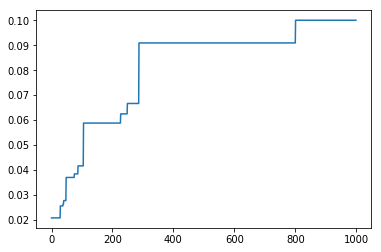

In [62]:
start_time = timeit.default_timer()

abm = abmClassifier(X_train, y_train)
abm.fit()
abm_pred = abm.predict(X_test)

print("Time: ", timeit.default_timer() - start_time)


cm = confusion_matrix(y_test, abm_pred)
print("\t\t\t\t---Our Own Logistic Regression with ABM---")
print("confusion_matrix:\n", cm)
print("accuracy_score: ", accuracy_score(y_test, abm_pred))

plt.plot(abm.performanceOverTime)

In [63]:
len(abm.population)

20